<a href="https://colab.research.google.com/github/Suryansh109/project_covid_v1/blob/master/DDos_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#setting up the spark and hadoop setup
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install -q findspark
#installing kaggle library to fetch the dataset  directly from kaggle and load it colab cluster
!pip install -q kaggle

In [ ]:
import os

os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]="/content/spark-3.0.1-bin-hadoop3.2"


In [ ]:
#finding spark and setting up the spark session.
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
#to make kaggle.json directory 
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"suryansh1001","key":"9814931985ed3e83f62d48c7bb58f7b2"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# this command helps to download the  dataset directly from the kaggle database
!kaggle datasets download -d devendra416/ddos-datasets

100% 2.67G/2.68G [00:33<00:00, 93.0MB/s]
100% 2.68G/2.68G [00:33<00:00, 86.0MB/s]


In [ ]:
#!mkdir ddos_raw_data
!unzip ddos-datasets.zip -d ddos_raw_data

Archive:  ddos-datasets.zip
  inflating: ddos_raw_data/ddos_balanced/final_dataset.csv  
  inflating: ddos_raw_data/ddos_imbalanced/unbalaced_20_80_dataset.csv  


In [ ]:
!ls -ltr  ddos_raw_data/*/*

-rw-r--r-- 1 root root 6794744782 Oct 22  2019 ddos_raw_data/ddos_balanced/final_dataset.csv
-rw-r--r-- 1 root root 4121715182 Oct 22  2019 ddos_raw_data/ddos_imbalanced/unbalaced_20_80_dataset.csv


In [52]:
balanced_data=spark.read.option("header",True).option("inferSchema",True).format("csv").load("ddos_raw_data/ddos_balanced/final_dataset.csv")

In [ ]:
from pyspark.sql import functions

In [53]:
#to perform  any arithmetical operation the datatypes of schema should be understood, hence checking out the schema.
balanced_data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Flow ID: string (nullable = true)
 |-- Src IP: string (nullable = true)
 |-- Src Port: integer (nullable = true)
 |-- Dst IP: string (nullable = true)
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: double (nullable = true)
 |-- TotLen Bwd Pkts: double (nullable = true)
 |-- Fwd Pkt Len Max: double (nullable = true)
 |-- Fwd Pkt Len Min: double (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: double (nullable = true)
 |-- Bwd Pkt Len Min: double (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nul

In [ ]:
balanced_data.count()

12794627

In [ ]:
balanced_data.show()

+---+--------------------+-------------+--------+------------+--------+--------+--------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+------------------+------------------+---------------+---------------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------------+-----------+-----------------+------------------+-----------+-----------+-----------+-----------------+------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+------------------+------------------+-----------+-----------+-----------------+------------------+-----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+--------------+----------------+------------

In [ ]:
#checking different attacks with highest on the Top 
attack_group=balanced_data.groupBy("label").count().orderBy("count",ascending=False)

In [ ]:
attack_group.cache()

DataFrame[label: string, count: bigint]

In [ ]:
import pandas as pd

In [ ]:
attack_group_pd=attack_group.toPandas()

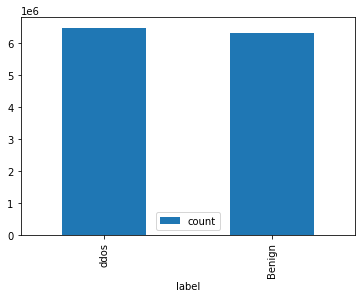

In [ ]:
# from the available dataset,we can infer that both the types of attack are almost in vicinity.
import matplotlib.pyplot as plt
attack_group_pd.plot(kind='bar',x='label',y='count')
plt.show()

In [ ]:
attack_group_pd

,label,count
0,ddos,6472647
1,Benign,6321980


In [45]:
#checking flowid through which the types of attacks has been done most
balanced_data.groupBy("label").agg({"Flow Duration":"sum"}).show()


+------+------------------+
| label|sum(Flow Duration)|
+------+------------------+
|  ddos|2.0193915332131E13|
|Benign|8.4972712104317E13|
+------+------------------+



In [71]:
from pyspark.sql.types import *
from matplotlib import pyplot
hourly_flow=balanced_data.select(functions.from_unixtime(functions.unix_timestamp('Timestamp', 'MM/dd/yyyy hh:mm:ss a')).cast(TimestampType()).alias("timestamp"),"Flow Duration").groupBy(functions.hour("timestamp"))\
.agg({"Flow Duration":"sum"}).orderBy("hour(timestamp)",ascending=True).toPandas()

In [111]:
#pyplot.scatter(hourly_flow["hour(timestamp)"],hourly_flow["sum(Flow Duration)"])

hourly_flow.rename(columns={'hour(timestamp)':'hours','sum(Flow Duration)':'total_flow_duration_per_hour'},inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [109]:
hourly_flow=hourly_flow.dropna()

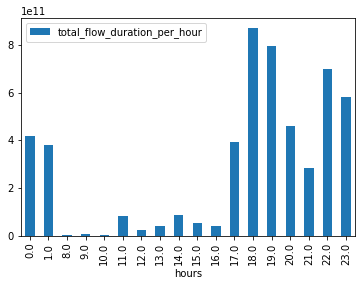

In [112]:
import matplotlib.pyplot as plt
hourly_flow.plot(kind='bar',x='hours',y='total_flow_duration_per_hour')
plt.show()